In [35]:
library(zoo)
library(data.table)

#### Limpeza dos dados
* dados ausentes
* upsamping e dowsampling
* suavização dos dados
* lidar com sazonalidade dos dados
* prevenir lookaheads não intencionais

In [36]:
unemp = fread('datasets/UNRATE.csv')

In [37]:
# Passando para data no R
unemp[,DATE:=as.Date(DATE)]

# definido a chave do dataframe
setkey(x = unemp, cols = DATE)

In [38]:
head( unemp, n = 2)

DATE,UNRATE
<date>,<dbl>
1948-01-01,3.4
1948-02-01,3.8


>Sim, é bem semelhante ao set_index do pandas em Python! Ambos são usados para definir colunas que servem como índices (ou chaves) para facilitar a ordenação e acelerar operações de busca e junções (joins).
>
> * No pandas: set_index é usado para definir uma ou mais colunas como índice do DataFrame.
> * No data.table (R): setkey serve para definir uma ou mais colunas como chave de um data.table, o que automaticamente ordena a tabela com base nessas colunas.

In [39]:
sample(1:10, 9, replace = TRUE)

[1] 5 6 4 2 1 3 8 9 6

In [40]:
# Gerando dados aleatoriamente ausentes

set.seed(seed = 1)
rand.unemp.idx = sample(1:nrow(unemp), .1*nrow(unemp))


rand.nan.unemp = unemp[-rand.unemp.idx]

In [41]:
# gera um conj. dados onde os dados possuem uma maior prob de ausencia quando é alto o desemprego

high.unemp.idx = which(unemp$UNRATE > 8)

num.to.select = .2 * length(high.unemp.idx)

high.unemp.idx = sample(high.unemp.idx, )

bias.unemp = unemp[-high.unemp.idx]

In [42]:
all.dates = seq(from = unemp$DATE[1], to = tail(unemp$DATE, 1), by='months')

In [43]:
rand.unemp = rand.nan.unemp[J(all.dates), roll=0]
bias.unemp = bias.unemp[J(all.dates), roll=0]

rand.unemp[, rpt := is.na(UNRATE)]

In [49]:
head( bias.unemp[is.na(UNRATE)],n = 2)

DATE,UNRATE
<date>,<dbl>
1975-01-01,NA
1975-02-01,NA


In [50]:
head( rand.unemp[is.na(UNRATE)],n = 2)

DATE,UNRATE,rpt
<date>,<dbl>,<lgl>
1949-10-01,NA,TRUE
1950-05-01,NA,TRUE


### Imputação

#### Forward Fill
* Ela transfere o útimo valor conhecido para o ausente 
    * ```r
        na.locf(VALOR, na.rm = FALSE)
    ```

In [62]:
vertor_ = c(1, NA, 2, 3, NA, NA, 5, 4, 2, NA)
vertor_

[1]  1 NA  2  3 NA NA  5  4  2 NA

In [ ]:
na.locf(vertor_, na.rm = TRUE)

[1] 1 1 2 3 3 3 5 4 2 2

In [65]:
na.locf(vertor_, na.rm = FALSE)

[1] 1 1 2 3 3 3 5 4 2 2

In [70]:
# Forward fill

rand.unemp[, impute.ff := na.locf(UNRATE,na.rm = FALSE)]
bias.unemp[, impute.ff := na.locf(UNRATE,na.rm = FALSE)]

NULL

NULL

NULL

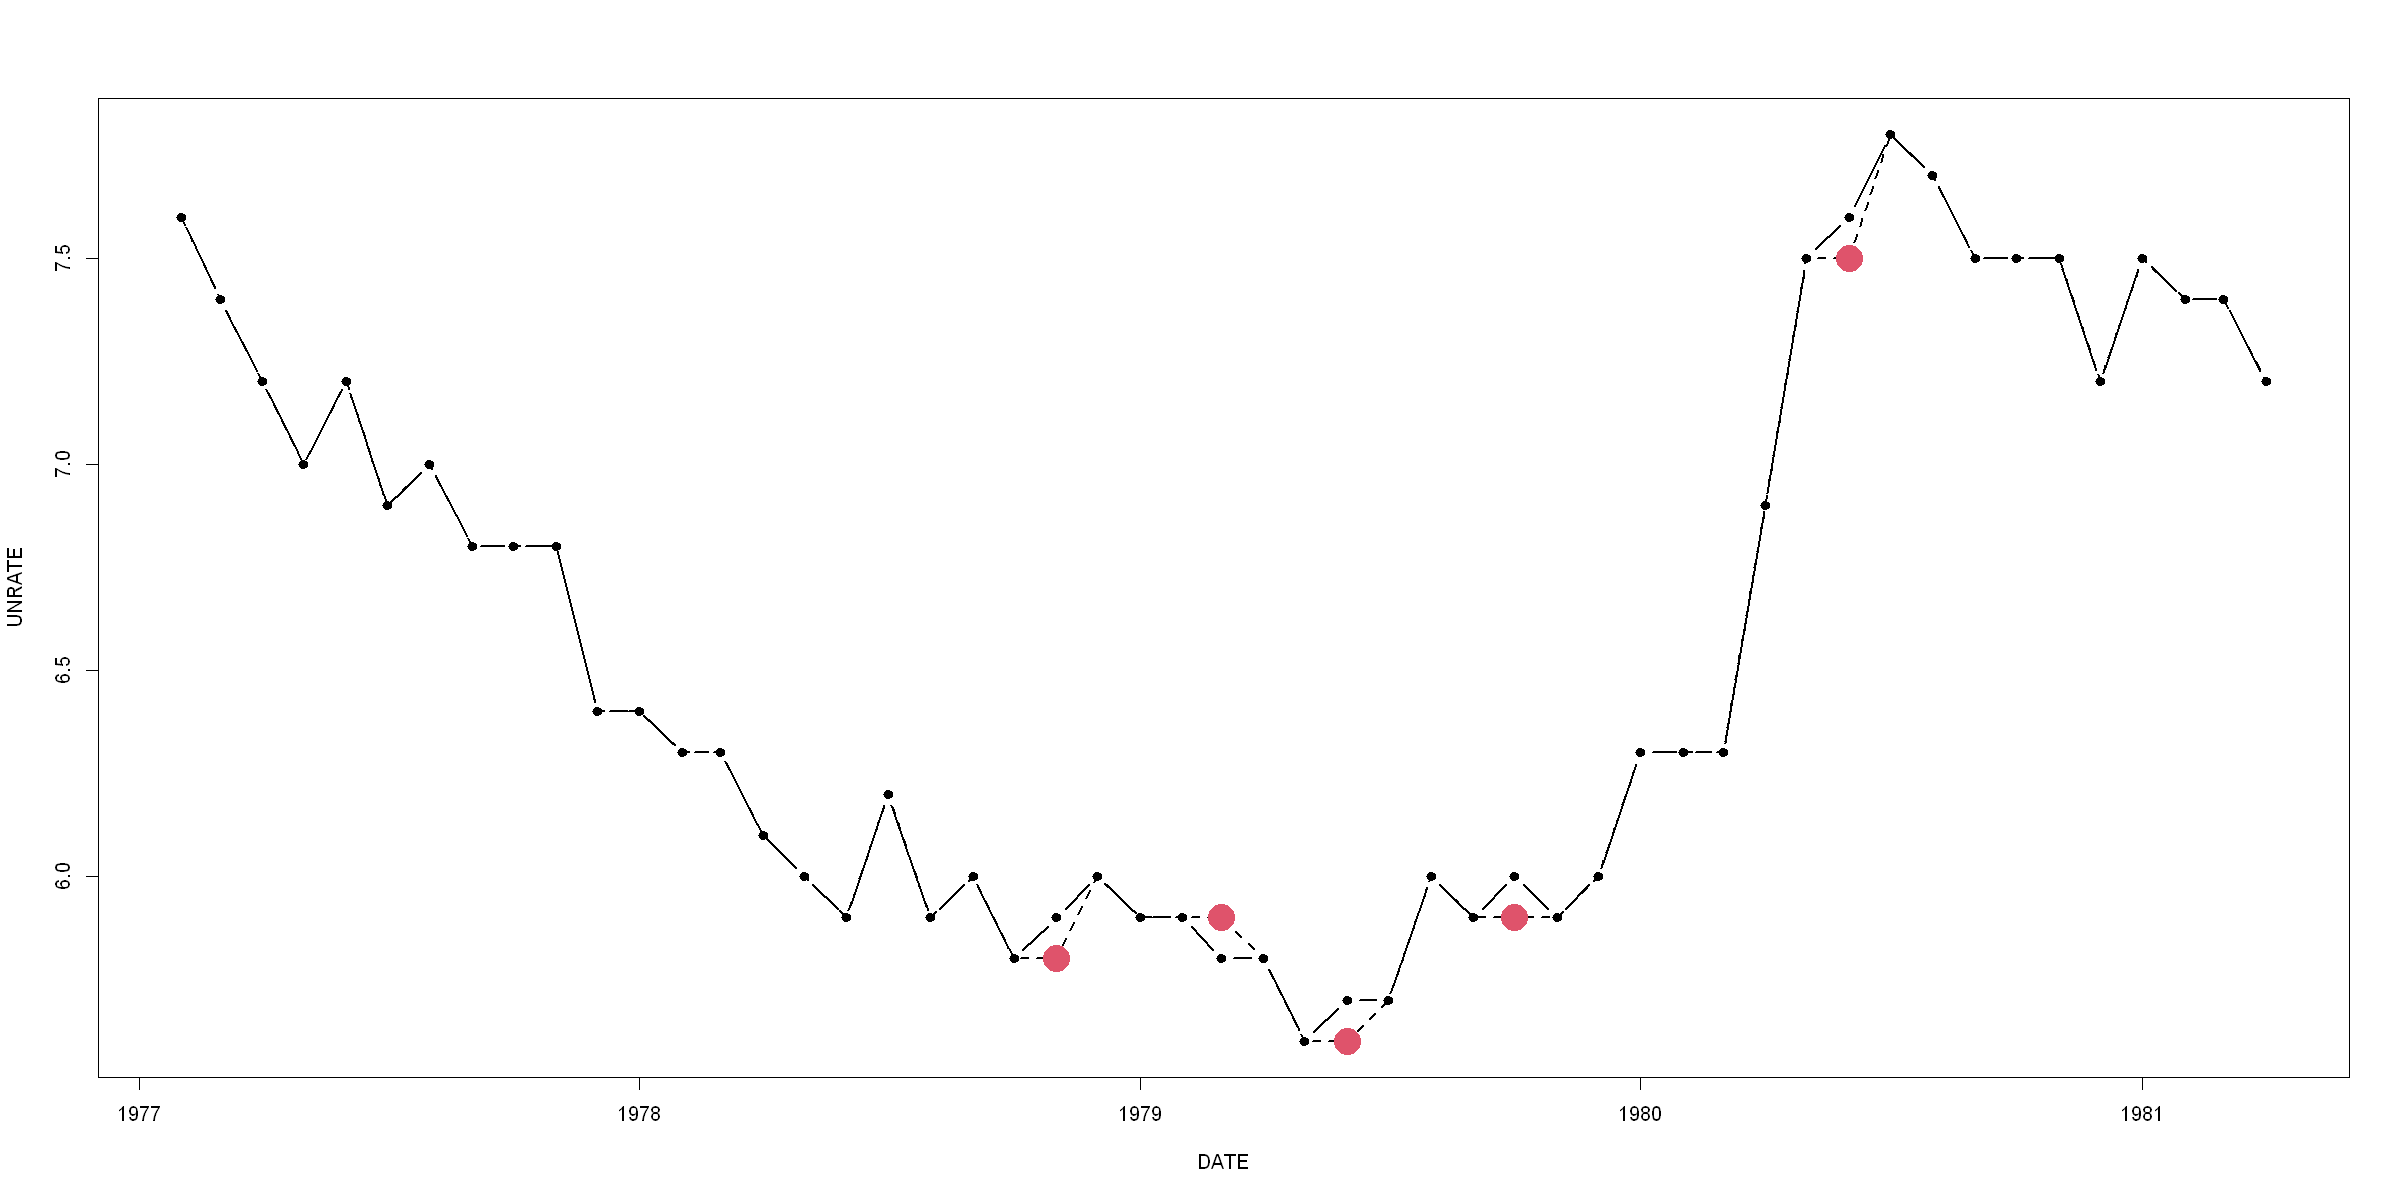

In [ ]:
par(bg='white')
options(repr.plot.width = 20, repr.plot.height = 10)


unemp[350:400, 
        plot( DATE, UNRATE, col=1, lwd=2, type='b', pch=19 )
    ]
rand.unemp[
    350:400, 
        lines( DATE, impute.ff, col=1, lwd=2, lty=2 )
    ]
rand.unemp[350:400][ rpt==TRUE, 
        points(DATE, impute.ff, col=2, pch=19, cex=3)
    ]

> As bolinhas é onde os valores foram imputados

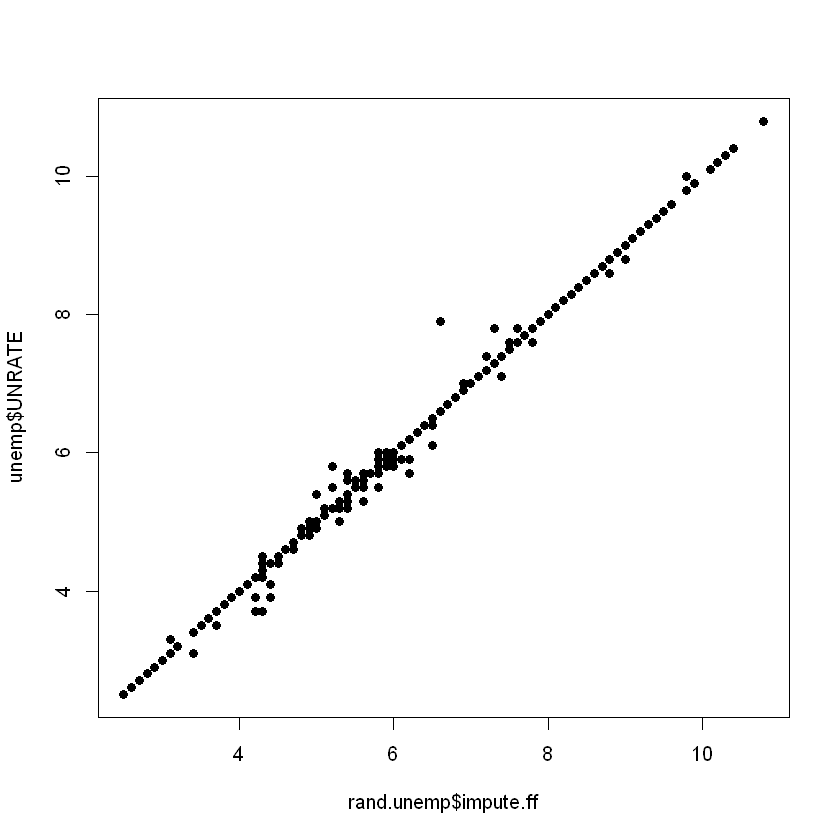

In [84]:
par(bg='white')
options(repr.plot.width = NULL, repr.plot.height = NULL)


plot(rand.unemp$impute.ff, unemp$UNRATE, pch = 19)

> Plotamos a taxe de desemprego real x imputados. Esses gráfico mostra que ff não distorceus sistematicamente os dados

> **EM ALGUNS AMBIENTES FORWARD FILL é a melhor maneria de preencher dados ausentes mesmo que métodos "mais sofisticados" seja possíveis.**

&nbsp;

#### Média movel
* Semelhante ao forward fill mas aplicando a média móvel
* Em diversa situações em que uma imputação de dados de média móvel melhor se adequa a tarefa em questão do que um Forward Fill:
    * Dados forem muito ruidosos 

```r
rollapply(c(NA, NA, vertor_), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)
```

In [86]:
vertor_

[1]  1 NA  2  3 NA NA  5  4  2 NA

In [106]:
rollapply(c(NA, NA, vertor_), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)

[1] 1.0 1.0 2.0 3.0 2.5 3.0 5.0 4.0 2.0 3.0

In [110]:
# média movel sem lookhead
rand.unemp[, imput.rm.nolookhead := rollapply(
    c(NA, NA, UNRATE), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)]

In [111]:
# média movel sem lookhead
bias.unemp[, imput.rm.nolookhead := rollapply(
    c(NA, NA, UNRATE), 3, 
    function(x){
        if (!is.na(x[3])) x[3] else mean(x, na.rm=TRUE)
    }
)]

**Média movés**